In [213]:
# Import packages
import os

import pandas as pd
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from functools import reduce

from dataclasses import dataclass
from dataclasses import InitVar
from typing import Type, List, Optional, Dict

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.api import formula as smf

import warnings

In [214]:
# Set up input file directories
os.chdir('')

## 1. Bioaccumulation model functions

Read in model functions

In [198]:
# 1. Dataclasses for input parameters and submodels

@dataclass  
class Settings():
    """ Switches that control the use of alternative versions of variable parameterizations for 
    different model applications or model development/testing.
    
    Parameters with default settings across lab and field studies are given default values
    Parameters that vary between lab and field model versions are not given default values"""
    
    # all fish models
    chooseEd: str = 'adult' # juv or adult
    chooseDiet: str = 'modeledDiet'    # obsDiet or modeledDiet
    chooseStudyType: str = 'default' 
    chooseRenal: str = 'on' # 'on' (with renal elimination) or 'off' (without renal elimination)
    chooseDmw: str = 'Droge'
    chooseEw: str = 'empirical'
    
    # food web models
    chooseKoc: str = 'Koc_Munoz' 
    # placeholder for lab-controlled studies with no sediment; this parameter will have no effect on modeled concentration
    
        
@dataclass
class Environment():
    """ Dataclass for model parameters and input parameters that vary by ecosystem"""
    
    C_OX: float # dissolved oxygen concentration (mg/L)
    T: float  # temperature (C)
    C_SS: float # concentration of suspended solids (kg/L)
    OCS: float # organic carbon content of the sediment (kg/L)
    pH: float # pH
    pHi: float = 7.4 # default for internal pH as suggested by Armitage et  al. 2013
        
    def __post_init__(self):
        self.pHg = self.pH - 1       
           

@dataclass 
class Chemical():
    """ Dataclass that holds parameters unique to each PFAS chemical. Parameters include physiochemial properties, pH-dependent properties (varies with environment), 
    and empirically-derived parameter values (sometimes varies with organism characteristics/study; this choice is made
    during the instantiation of this class)
    
    Functions include calculation of chemical-specific parameters, which may depend on environmental parameters (class Environment)"""
    
    Log_Kow: float 
    Log_Kpw: float
    Log_Dmw: float
    pKa: float
    Ed_exp: float
    Ew_exp: float
    Log_Koc: float
    k_R_est: float
    chemID: int
    env: InitVar[Environment]
    
    
    def __post_init__(self, env: Environment):
        self.K_OW = 10**self.Log_Kow
        self.K_PW = 10**self.Log_Kpw
        self.D_MW_exp = 10**self.Log_Dmw
        self.K_OC = 10**self.Log_Koc
        
        self.D_OW = self.getD_OW(env)
        
    def getD_OW (self, env: Environment):
        """ Octanol-water distribution coefficient (Armitage et al. 2013)"""        
        Xn = 1 / (1 + 10**(env.pHi-self.pKa)) # neutral fraction of the compound
        Xi = 1 - Xn # ionic fraction of the compound

        logK_OW_i = np.log10(self.K_OW) - 3.1# based on Armitage et al 2013, see SI Table S7
        K_OW_i = 10 ** logK_OW_i 

        D_OW = Xn * self.K_OW + Xi * K_OW_i        
        
        assert np.log10(D_OW) > 0, 'error in D_OW calculation (negative value)' 
        
        return D_OW
        
    def getD_MW (self, env: Environment, settings: Settings): 
        if settings.chooseDmw in ('Droge') :
            D_MW = self.D_MW_exp
        elif settings.chooseDmw == 'calculated': 
            Xn = 1 / (1 + 10**(env.pHi-self.pKa)) # neutral fraction of the compound
            Xi = 1 - Xn # ionic fraction of the compound

            a = 1.01 # Endo et al, as cited in Armitage et al 2013, Table S2
            b = 0.12 # Endo et al, as cited in Armitage et al 2013
            logK_MW_n = (a * np.log10(self.K_OW)) + b
            K_MW_n = 10**logK_MW_n

            logK_MW_i = np.log10(K_MW_n) - 2 # based on Armitage et al 2013, see SI Table S7
            K_MW_i = 10**logK_MW_i

            D_MW = Xn * K_MW_n + Xi * K_MW_i
        else:
            assert 'error in D_MW choice'

        assert np.log10(D_MW) > 0, "error in D_MW calculation (negative value)"
        
        return D_MW
    
    
    def getE_W(self, env: Environment, settings: Settings):  
        """ Fish gill uptake efficiency (%)
        Used to calculate k1 clearance rate constant for fish, invertebrates, and zooplankton  
        """
        
        if 'beta' in settings.chooseEw:
            pHg = env.pHi - 1
            Ew_mu = 1 + 10**(pHg - self.pKa)
            Ew_beta = float(settings.chooseEw.replace('beta',''))
            E_W = (1 / (1.85 + (Ew_mu * 155/self.K_OW))) + Ew_beta 
        elif settings.chooseEw in ('empirical'):
            E_W = self.Ew_exp
        else:
            assert 'error in Ew selection'
            
        return E_W
            
   
    def getE_D(self, settings: Settings): 
        """ Dietary chemical transfer efficiency (%) 
        Used to calculate kd uptake rate constant. 
        Empirical values for PFAAs differ for juvenile and adult fish
        """
        
        if settings.chooseEd == 'calculated': 
        # note that Aed and Bed are based on empirical relationships that are highly variable; these are for fish 
            A_ED = 3 *  10**(-7) # front Arnot & Gobas 2004
            B_ED = 2
            E_D = (A_ED * self.K_OW  + B_ED)**(-1)
        elif settings.chooseEd in ('juv','adult'):
            E_D = self.Ed_exp
        else:
            assert 'error in Ed selection'
            
        return E_D
    
    
@dataclass
class Organism():
    """ Dataclass that holds parameters unique to each organism, or the calculation of parameters that may vary
    depending on organism type (i.e. sigma, beta)
    
    Functions include calculations of (1) diet composition; (2) bioenergetic rates; (3) partitioning coefficients;
    and (4) chemical uptake and elimination rate constants"""

    W_B: float
    m_O: float
    GRF: float
    
    nu_NB: float
    nu_LB: float
    nu_PB: float
    nu_OB: float
    nu_WB: float
    
    nu_ND: float
    nu_LD: float
    nu_PD: float
    nu_OD: float
    nu_WD: float
    
    epsilon_N: float
    epsilon_L: float
    epsilon_P: float
    epsilon_O: float
    epsilon_W: float

    switchk_1: int
    switchG_D: int
    switchk_R: int
        
    A: float
    B: float
    sigma: float 
    
    # Diet functions
    def _getnu_NG(self):
        nu_NG = (1 - self.epsilon_N) * self.nu_ND / ((1- self.epsilon_N) * self.nu_ND + (1 - self.epsilon_L) * self.nu_LD + 
                                    (1 - self.epsilon_P)* self.nu_PD + (1 - self.epsilon_O) * self.nu_OD + (1 - self.epsilon_W) * self.nu_WD)
        return nu_NG

    def _getnu_LG(self):
        nu_LG = (1 - self.epsilon_L) * self.nu_LD / ((1- self.epsilon_N) * self.nu_ND + (1 - self.epsilon_L) * self.nu_LD + 
                                           (1 - self.epsilon_P)* self.nu_PD + (1 - self.epsilon_O) * self.nu_OD + (1 - self.epsilon_W) * self.nu_WD)
        return nu_LG

    def _getnu_PG(self):
        nu_PG = (1 - self.epsilon_P) * self.nu_PD / ((1- self.epsilon_N) * self.nu_ND + (1 - self.epsilon_L) * self.nu_LD + 
                                           (1 - self.epsilon_P)* self.nu_PD + (1 - self.epsilon_O) * self.nu_OD + (1 - self.epsilon_W) * self.nu_WD)
        return nu_PG

    def _getnu_OG(self):
        nu_OG = (1 - self.epsilon_O) * self.nu_OD / ((1- self.epsilon_N) * self.nu_ND + (1 - self.epsilon_L) * self.nu_LD + 
                                           (1 - self.epsilon_P)* self.nu_PD + (1 - self.epsilon_O) * self.nu_OD + (1 - self.epsilon_W) * self.nu_WD)
        return nu_OG

    def _getnu_WG(self):
        nu_WG = (1 - self.epsilon_W) * self.nu_WD / ((1- self.epsilon_N) * self.nu_ND + (1 - self.epsilon_L) * self.nu_LD + 
                                           (1 - self.epsilon_P)* self.nu_PD + (1 - self.epsilon_O) * self.nu_OD + (1 - self.epsilon_W) * self.nu_WD)
        return nu_WG
    

    # Organism functions
    
    def _getG_V(self, env: Environment, settings: Settings):
        "G_V is the ventilation rate. C_OX is the dissolved oxygen concentration (mg/L)"
        
        G_V = 1400 * (self.W_B**.65) / env.C_OX 
        
        return G_V

    def _getG_D(self, env: Environment, settings: Settings): 
        """ G_D is the feeding rate
        G_Dswitch determines which formula to use based on the type of organism and data availability
        1 should be used to estimate G_D for coldwater fish species, and in some cases, zooplankton
        2 should be used to estimate G_D for filter-feeding species
        Use empirical data where available, though be careful about the energetic content of food and associated growth rates"""

        if self.switchG_D == 0:
            return float('NaN') 
        elif self.switchG_D == 1: 
        # Note that several studies have observed decreasing concentrations with increasing fish length w/in the same species
        # This could potentially be due to growth dilution, onotogenetic shifts, or other processes, not necessarily feeding rate
            G_D = 0.022 * self.W_B**0.85 * np.exp(0.06*env.T) 
            return G_D
        elif self.switchG_D == 2:        
            #G_V is the gill ventilation rate
            #C_SS is the concentration of suspended solids
            #sigma is the scavenging efficiency of particles
            G_V = self._getG_V(env, settings)
            G_D = G_V * env.C_SS * self.sigma
            return G_D    
        else:
            return "error in getG_D: wrong input for switchG_D argument"
    
    def _getG_F(self, env: Environment, settings: Settings): 
    # G_F is the fecal egestion rate
    # epsilon_L, epsilon_N, and epsilon_W are the dietary assimilation efficiencies of lipid, NLOM and water, respectively.
    # nu_LD, nu_ND, and nu_WD are the overall lipid, NLOM and water contents of the diet, respectively.
        G_D = self._getG_D(env, settings)
        G_F = ((1 - self.epsilon_N) * self.nu_ND + (1 - self.epsilon_L) * self.nu_LD + (1 - self.epsilon_P) * self.nu_PD + (1 - self.epsilon_O) * self.nu_OD + (1 - self.epsilon_W) * self.nu_WD) * G_D

        return G_F
    
    
    # Partitioning coefficients
    
    def getD_BW (self, chem: Chemical, env: Environment, settings: Settings):
        D_OW = chem.getD_OW(env)
        D_MW = chem.getD_MW(env, settings)

        if self.switchk_1 == 0:
            Beta = 0.35  
        else:
            Beta = 0.05 
        
        D_BW = self.nu_NB * D_OW + self.nu_LB * D_MW + self.nu_PB * chem.K_PW + self.nu_OB * D_OW * Beta + self.nu_WB
        
        return D_BW
    

    def _getK_GB(self, chem: Chemical, env: Environment, settings: Settings):
        """ K_GB is the partition coefficient of the chemical between the contents of GIT and the oragnism.
        nu_NG, nu_LG, nu_PG and nu_WG are the neutral lipid, phospholipid, protein and water contents,respectively, in the gut."""

        nu_NG = self._getnu_NG() 
        nu_LG = self._getnu_LG()
        nu_PG = self._getnu_PG()
        nu_OG = self._getnu_OG()
        nu_WG = self._getnu_WG()

        D_OW = chem.getD_OW(env)
        D_MW = chem.getD_MW(env, settings)
        D_BW = self.getD_BW(chem, env, settings)
        
        D_GW = nu_NG * D_OW + nu_LG * D_MW + nu_PG * chem.K_PW + nu_OG * D_OW * 0.05 + nu_WG

        K_GB = D_GW / D_BW
        
        return K_GB


    def _getK_BU (self, chem: Chemical, env: Environment, settings: Settings):
        # K_BU is the partition coefficient between the organism and urine C_B/C_U

        #K_BW is the organism water partition coefficient
        #nu_LB is the lipid fraction (kg lipid/kg organisms ww)
        #nu_NB is the NLOM fraction (kg NLOM/kg organism ww)
        #nu_WB is the water content (kg water/kg organism ww) of the organism
        #Beta is a proportionality constant expressing the sorption capacity of NLOM to that of octanol
        #.035 is a reasonable estimate of Beta

        LipidDensity=0.9 # kg/L
        PLipidDensity=0.9 # kg/L (Armitage et al. 2013)
        ProteinDensity= 1.35 # g/cm3 = kg/L (Fischer et al. 2009; Allendorf et al. 2020) 
        NLOMDensity=1 # kg/L

        D_OW = chem.getD_OW(env)
        D_MW = chem.getD_MW (env, settings)
        
        K_BU = (self.nu_NB * D_OW / LipidDensity) + (self.nu_LB * D_MW / PLipidDensity) + (self.nu_PB * chem.K_PW / ProteinDensity) + (self.nu_OB * D_OW * 0.05 / NLOMDensity) + self.nu_WB
        
        return K_BU
    
    
    # Rate constant functions 
    
    def getk_1(self, chem: Chemical, env: Environment, settings: Settings):
        """ k_1 is the clearance rate constant (L/kg*d) for chemical uptake via respiratory area (i.e., gills and skin) """
    
    
        if self.switchk_1 == 0:    
            #A and B are constants describing the reistance to chemical uptake 
            #through aqueous (A) and organic phases (B) of the algae, phytoplankton, or macrophyte.
            #A default value = 6x10^-5 for PCBs in Arnot & Gobas 2004; 8.2 x 10^-3 in Gobas & MacKay 1987
            #B default value = 5.5 for PCBs in Arnot & Gobas 2004; 0.68 in Gobas & MacKay 1987
            # difference between these two options is minimal

            #k_1 for algae, phytoplankton, and aquatic macrophytes

            k_1 = 1/(self.A + (self.B / chem.D_MW_exp))
            
            return k_1

        elif self.switchk_1 == 1:

            #G_V is ventilation rate (should be able to find and not use equation)
            #G_V can be approximated by G_V = 1400 * (W_B^.65)/C_OX where C_OX = (-.24*T + 14.04) * S
            #W_B is the wet weight of the organism (kg)
            #E_W is the gill chemical uptake efficiency

            G_V = self._getG_V(env, settings)
            E_W = chem.getE_W(env, settings)

            #k_1 for fish, invertebrates, and zooplankton
            k_1 = E_W * G_V / self.W_B

            return k_1
        
            
    def getk_D(self, chem: Chemical, env: Environment, settings: Settings): 
        """ Dietary uptake clearance constant (kg food/kg organism per day)
        The rate at which chemicals are absorbed from the diet via the GIT"""
        #E_D is the dietary chemical transfer efficiency
        #G_D is the feeding rate (kg food/day) - empirical data often available
        #W_B is the weight of the organism (kg organism) 
        E_D = chem.getE_D(settings)
        G_D = self._getG_D(env, settings)

        k_D = E_D * G_D / self.W_B

        return k_D
    
    def getk_E(self, chem: Chemical, env: Environment, settings: Settings):
        """ Fecal elimination rate constant: the rate at which chemicals are eliminated by the egestion of fecal matter (1/d) """
        #G_F is the fecal egestion rate (kg-feces/kg-organism/day)
        #E_D is the dietary chemical transfer efficiency
        #K_GB is the partition coefficient of the chemical between the GIT and the organism.
        #W_B is the weight of the oyrganism
        #epsilon_L, epsilon_N, and epsilon_W are the dietary assimilation efficiencies of lipid, NLOM, and water, respectively
        #nu_LD, nu_ND, and nu_WD are the overall lipid, NLOM, and water contents of the diet

        G_F = self._getG_F(env, settings)
        E_D = chem.getE_D(settings)
        K_GB = self._getK_GB(chem, env, settings)

        k_E = G_F * E_D * K_GB / self.W_B

        return k_E
    
    def getk_G(self, settings: Settings):
        """ Growth rate constant. 
        W_B is the weight of the organism at time t, 
        GRF is the growth rate factor that differs by organism and temperature"""
        if settings.chooseStudyType in ('default','reduced feeding'):
            if self.switchk_1 ==0: # algae, phytoplankton, macrophytes
                k_G = self.GRF # GRF input for phytoplankton is simply the growth rate constant 
                return k_G
            elif self.switchk_1 == 1: # fish, invertebrates
                k_G = self.GRF* self.W_B**(-0.2) 
                return k_G
            else:
                return 'error in getk_G: wrong input for switchk_1 argument'
        elif settings.chooseStudyType in ('Martin BCF', 'Martin BMF', 'Martin BMF rev'):
            return 0 
        else:
            return 'error in getk_G: wrong input for chooseStudyType argument'
    

@dataclass
class ChemData():
    """ Dataclass that holds chemical data that is unique to each model system. This includes both model parameters and input variables"""
    
    C_WTO: float
    C_s: float
    Phi: float # should be < 1; default is 1 for the lab studies if this is not used
        
    def getC_WDP(self, chem: Chemical, env: Environment, settings: Settings):
        """ Freely dissolved chemical concentration in the sediment associated pore (or interstitial) water (g/L)"""
    #C_WDP = C_SOC / K_OC where C_SOC is the chemical concentration in sediment normalized for OC content (g/kg-OC)
            
    #Cs is the Concentration in sediment
    #OCS is the organic carbon content of the sediment
    #Koc is the organic carbon partitioning coefficient; Koc = Kd / OCS 
    
        C_WDP = (self.C_s / env.OCS) / chem.K_OC

        return C_WDP
        
        


In [199]:
# 2. Steady State Equation for calculating concentration in a single organism

def getSSC_B(settings: Type[Settings], chemdata: Type[ChemData], C_D: float, P: List[float], Pd: pd.DataFrame, \
             env: Type[Environment], chem: Type[Chemical], org: Type[Organism], kRTable: Optional[pd.DataFrame]=None):
        
        ##############################################
        ## Calculate intermediate model inputs & rates
        ##############################################
        
        C_WDP = chemdata.getC_WDP(chem, env, settings) 

        k_1 = org.getk_1(chem, env, settings) #k_1 is the clearance rate constant (L/kg*d) for chemical uptake via respiratory area
        k_2 = k_1 / org.getD_BW(chem, env, settings)
        
        if org.switchk_1 == 0: # Phytoplankton
            k_D = 0
            k_E = 0
            k_G = org.GRF
        elif org.switchk_1 == 1: # Zooplankton, Aquatic Invertebrates, Fish
            k_D = org.getk_D(chem, env, settings) 
            #k_E is the rate constant (1/d) for chemical elimination via exretion into egested feces
            k_E = org.getk_E(chem, env, settings) 
            #k_G is the growth rate constant
            k_G = org.getk_G(settings) 
        else:
            return 'error in k1 switch selection for dietary & growth uptake & elimination pathways'
    
        k_M = 0
            
        # Renal elimination rate
        if settings.chooseRenal == 'on':
            if org.switchk_R == 1:
                k_R_est = chem.k_R_est * k_2
            elif org.switchk_R == 0:
                k_R_est = 0
            else:
                assert 'error in kR switch'
        elif settings.chooseRenal == 'off':
            k_R_est = 0
        else:
            return 'error in renal elimination settings'
        
        ##################################
        ## Calculate tissue concentration 
        ##################################
        C_B = ((k_1 * (org.m_O * chemdata.Phi * chemdata.C_WTO + (1-org.m_O) * C_WDP) + \
                k_D * (sum(P * C_D) + (Pd * chemdata.C_s))) / (k_2 + k_E + k_M + k_G+ k_R_est))
        
       
        #################################
        ## Create table of output values 
        ################################
        D_OW = chem.getD_OW(env)
        D_MW = chem.getD_MW(env, settings)
        D_BW = org.getD_BW(chem, env, settings)
                       
        G_F = org._getG_F(env, settings)
        #G_F = 0
        G_D = org._getG_D(env, settings)
        #G_D = 1
        G_V = org._getG_V(env, settings)
        E_D = chem.getE_D(settings)
        K_GB = org._getK_GB(chem, env, settings)
        E_W = chem.getE_W(env, settings)

        Diet = sum(P * C_D) + (Pd * chemdata.C_s)
        Water = (org.m_O * chemdata.Phi * chemdata.C_WTO + (1-org.m_O) * C_WDP)
        FeedRate = G_D / org.W_B
        Gill_uptake = k_1 * (org.m_O * chemdata.Phi * chemdata.C_WTO + (1-org.m_O) * C_WDP) # L/kg*d * ng/mL (or g/L) = g chemical/kg fish/day
        Dietary_uptake = k_D * (sum(P * C_D) + (Pd * chemdata.C_s)) # kg food/kg org * ng/g (or g/kg food) = g chemical/kg fish/day
        Uptake = Gill_uptake + Dietary_uptake
        Gill_uppct = Gill_uptake / Uptake
        Diet_uppct = Dietary_uptake / Uptake
        TotalElim_rate = (k_2 + k_E + k_M + k_G)
        
        #FoodP = sum(P)
        #FoodD = sum(C_D)
        #Sediment = Pd * C_s
        
        NL_pct = (org.nu_NB * D_OW) / D_BW
        PL_pct = (org.nu_LB * D_MW) / D_BW
        Protein_pct = (org.nu_PB * chem.K_PW) / D_BW
        NLOM_pct = (org.nu_OB * D_OW * 0.05) / D_BW
        water_pct = (org.nu_WB) / D_BW   
        
        kr_pct = k_R_est / (k_2 + k_E + k_G + k_R_est)
        
        
        
        Output_Data = np.array([C_B, org.m_O, chemdata.Phi,chemdata.C_WTO, C_WDP, Water, chemdata.C_s, FeedRate, Diet, Gill_uptake, Dietary_uptake, Gill_uppct, Diet_uppct, G_V, G_D, G_F, org.W_B, E_W, E_D, 
                                k_1, k_2, k_D, k_E, k_G, k_R_est, TotalElim_rate, kr_pct, chem.pKa, np.log10(D_BW), chem.Log_Kow, np.log10(D_MW), np.log10(D_OW), chem.Log_Kpw, 
                                D_BW, D_MW, D_OW, chem.K_PW, env.pHi, env.pHg, K_GB, org.nu_NB, org.nu_LB, org.nu_PB, org.nu_OB, org.nu_WB, 
                                org.epsilon_N, org.epsilon_L, org.epsilon_P, org.epsilon_O, chem.Log_Koc,chemdata.Phi])

        return Output_Data


In [200]:
# 3. Food Web Model

def BioaccumulationModel(PFAA: str, settings_dict: Dict[str,pd.DataFrame], numSpecies: int, oceanData: pd.DataFrame, \
                         chemicalData: pd.DataFrame, chemicalParams: pd.DataFrame, organismData: pd.DataFrame, \
                         foodWebData: pd.DataFrame, dietData:Optional[pd.DataFrame]=None, kRTable:Optional[pd.DataFrame]=None): 
    
    #######################
    # Set up model settings
    #######################
    settings = Settings(**settings_dict)
    chemicalData = chemicalData[PFAA]
    chemicalParams = chemicalParams[PFAA]
    if dietData is not None:
        dietData = dietData[PFAA]
    
    ####################
    # Read in parameters
    ####################
    ## Ocean Parameters
    C_OX = oceanData.loc['C_OX'] #Dissolved Oxygen Concentration (mg/L)
    T = oceanData.loc['T'] #Temperature (C)
    C_SS = oceanData.loc['C_SS'] #Concentration of suspended solids (kg/L)
    OCS = oceanData.loc['OCS'] #Organic carbon content of the sediment (fraction)
    pH = oceanData.loc['pH'] # ocean pH 
    pHi = 7.4 # default for internal pH as suggested by Armitage et  al. 2013.
    pHg = pH - 1 

    ## Chemical Parameters
    Log_Kow = chemicalParams.loc['Log_Kow_COSMOtherm']
    Log_Kpw = np.log10(1.36 * 10**chemicalParams.loc['log_Kpw_Allendorf'])
    Log_Dmw = chemicalParams.loc['log_Dmw_droge'] # Dmw measured by Droge 2019
    pKa = chemicalParams.loc['pKa_Armitage'] 
    Log_Koc = chemicalParams.loc['log_Koc_Munoz'] # choose values relevant for model system
    E_W_exp = chemicalParams.loc['E_W_Martin10'] # calculated at Cox = 10 mg/L. Estimated based on T=12, DO sat approximately 92%
    k_R_est = chemicalParams.loc['krkb_ratio'] # calculated 
    
    # Ed
    if settings.chooseEd == 'juv':
        E_D_exp = chemicalParams.loc['E_D_Martin2003']
    elif settings.chooseEd == 'adult':
        E_D_exp = chemicalParams.loc['E_D_Goeritz']
    else:
        assert 'error in Ed selection'
        
    # chemID
    chemID = chemicalParams.loc['chemID']
    
    
    ## Organism Parameters
    W_B = organismData.loc['W_B',:]  #Final Weight of the organism (kg)
    m_O = organismData.loc['m_O',:] #Fraction of the respiratory ventilation that involves overlying water
    
    nu_NB = organismData.loc['nu_NB',:]  #Neutral lipid fraction
    nu_LB = organismData.loc['nu_LB',:]  #Phosphoipid fraction
    nu_PB = organismData.loc['nu_PB',:]  #Protein fraction
    nu_OB = organismData.loc['nu_OB',:]  #NLOM (or "other") fraction
    nu_WB = organismData.loc['nu_WB',:]  #Water content
    
    epsilon_N = organismData.loc['epsilon_N',:]  #Dietary assimilation efficiency of neutral lipid contents of diet (fraction)
    epsilon_L = organismData.loc['epsilon_L',:]  #Dietary assimilation efficiency of phospholipid contents of diet ((fraction)
    epsilon_P = organismData.loc['epsilon_P',:]  #Dietary assimilation efficiency of protein contents of diet (fraction)
    epsilon_O = organismData.loc['epsilon_O',:]  #Dietary assimilation efficiency of the NLOM content of diet (fraction)
    epsilon_W = organismData.loc['epsilon_W',:]  #Dietary assimilation efficiency of water contents of diet (fraction)
    
    A = organismData.loc['A',:]  #Aqueous phase resistance constant for k1 calculation
    B = organismData.loc['B',:]  #Organic phase resistance constant for k1 calculation
    GRF = organismData.loc['GRF',:] #growth weight factor
    
    switchk_1 = organismData.loc['switchk_1',:] #dependent on organism type
    switchG_D = organismData.loc['switchG_D',:]  #dependent on organism type
    switchk_R = organismData.loc['switchk_R',:] # dependent on organism type
    
    sigma =  1 # sigma is the scavenging efficiency of particles
    Beta =  0.035 # Proportionality constant representing the sorption capacity of NLOM to that of octanol.
    # Beta is specifically relevant to calculating partitioning in phytoplankton, where NLOM is replaced with NLOC    
    
    
    ####################################
    # Read in system-specific parameters
    ####################################
    ## System-Specific Chemical Data
    C_WTO = chemicalData.loc['C_WTO'] #Total chemical concentration in the water column above the sediments (g/L)
    C_s = chemicalData.loc['C_s'] #.0358; %C_s is the Concentration in sediment
    Phi = chemicalData.loc['Phi_exp'] # Field-measured Phi reported for a given system
    
    # Food Web Data
    Pd=foodWebData.iloc[:,0] #Fraction of the diet consisting of detritus
    P=foodWebData.iloc[:,1:numSpecies+1] #Fraction of the diet consisting of prey item i 
    
    ###############################
    # Calculate dietary composition
    ###############################
    
    nu_ND = np.zeros(numSpecies)
    nu_LD = np.zeros(numSpecies)
    nu_PD = np.zeros(numSpecies)
    nu_OD = np.zeros(numSpecies)
    nu_WD = np.zeros(numSpecies)
    
    for i in range(numSpecies):
        
        if settings.chooseStudyType == 'default':
            nu_ND[i] = sum((P.iloc[i,:] * nu_NB)) #Overall neutral lipid content of diet
            nu_LD[i] = sum((P.iloc[i,:] * nu_LB)) #Overall phospholipid content of the diet
            nu_PD[i] = sum((P.iloc[i,:] * nu_PB)) #Overall protein content of the diet
            nu_OD[i] = sum((P.iloc[i,:] * nu_OB)) #Overall NLOM content of the diet
            nu_WD[i] = sum((P.iloc[i,:] * nu_WB)) #Overall water content of diet
    
    
    ######################
    # Instantiate classes
    ######################
    env = Environment(C_OX, T, C_SS, OCS, pH)
    chem = Chemical(Log_Kow, Log_Kpw, Log_Dmw, pKa, E_D_exp, E_W_exp, Log_Koc, k_R_est, chemID, env)
    chemdata = ChemData(C_WTO, C_s, Phi)

    
    ############################
    # Run model and save results
    ############################
    
    Parameters = np.array(['C_B','Phi','mO','C_WTO','C_WDP','Water','C_s','FeedRate','Diet','Gill_uptake','Dietary_uptake','Gill_up%','Diet_up%','G_V','G_D','G_F','W_B','Ew','Ed',
                       'k1','k2', 'kd','ke','kg','kr_est','Total Elimination','kr_pct','pKa','logDbw','log Kow', 'log Dmw','log Dow','log Kpw',
                       'D_BW','D_MW','D_OW','K_PW','pHi','pHg','K_GB','nu_NB','nu_LB','nu_PB','nu_OB','nu_WB','epsilon_N','epsilon_L','epsilon_P', 'epsilon_O',
                       'Log_Koc','Phi'])
    
    
    Results = np.zeros((numSpecies,len(Parameters)))
    Results = pd.DataFrame(Results, columns=Parameters)
    Results.set_index(organismData.columns.values, inplace=True)
    
    if settings.chooseDiet == 'modeledDiet':
        C_D = np.zeros(numSpecies)
        for i in range(0,numSpecies):
            orgi = Organism(W_B[i], m_O[i], GRF[i], nu_NB[i], nu_LB[i], nu_PB[i], nu_OB[i], nu_WB[i], 
                            nu_ND[i], nu_LD[i], nu_PD[i], nu_OD[i], nu_WD[i], epsilon_N[i], epsilon_L[i], epsilon_P[i], 
                            epsilon_O[i], epsilon_W[i], switchk_1[i], switchG_D[i], switchk_R[i],  A[i], B[i], sigma) 
            Results.iloc[i,:] = getSSC_B(settings, chemdata, C_D, P.iloc[i,:], Pd[i], env, chem, orgi,kRTable)
            C_D[i] = Results.iloc[i,0]
    elif settings.chooseDiet == 'obsDiet': # manual input
        # read in empirical diet data
        C_D = np.array(dietData)
        # insert modeled phytoplankton concentration, which is not empirically measured
        org0 = Organism(W_B[0], m_O[0], GRF[0], nu_NB[0], nu_LB[0], nu_PB[0], nu_OB[0], nu_WB[0], 
                        nu_ND[0], nu_LD[0], nu_PD[0], nu_OD[0], nu_WD[0], epsilon_N[0], epsilon_L[0], epsilon_P[0], 
                        epsilon_O[0], epsilon_W[0], switchk_1[0], switchG_D[0], switchk_R[0], A[0], B[0], sigma) 
        Results.iloc[0,:] = getSSC_B(settings, chemdata, C_D, P.iloc[i,:], Pd[i], env, chem, org0,kRTable)
        C_D[0] = Results.iloc[0,0]     
        for i in range(0,numSpecies):
            orgi = Organism(W_B[i], m_O[i], GRF[i], nu_NB[i], nu_LB[i], nu_PB[i], nu_OB[i], nu_WB[i], 
                            nu_ND[i], nu_LD[i], nu_PD[i], nu_OD[i], nu_WD[i], epsilon_N[i], epsilon_L[i], epsilon_P[i], 
                            epsilon_O[i], epsilon_W[i], switchk_1[i], switchG_D[i], switchk_R[i], A[i], B[i], sigma) 
            Results.iloc[i,:] = getSSC_B(settings, chemdata, C_D, P.iloc[i,:], Pd[i], env, chem, orgi,kRTable)
            
            
    # results post-processing
    Results['C_B'] = Results['C_B']*1000
    Results['logC_B'] = np.log10(Results['C_B'])
    Results['C_B_ngg'] = Results['C_B'] / 1000
    Results['logBAF'] = np.log10(Results['C_B_ngg'] / Results['C_WTO'])
    Results['BMF'] = Results['C_B_ngg'] / Results['Diet']

    return Results
    

    

## 2. Set up model inputs - modify for your system

Modify model settings and input files for your given system of interest  
Download input data files from the GitHub 'data' folder  

Add additional settings as desired to assess alternative model parameters

In [208]:
# Set up input files

GE_inputFiles = {
    'organismData': pd.read_csv('data/organismData_Munoz.csv',index_col=0), # organism characteristics unique to each food web
    'chemicalData': pd.read_csv('data/chemicalData_Munoz.csv',index_col=0), # input chemical concentrations
    'numSpecies': 12, # number of species in the food web
    'oceanData': pd.read_csv('data/oceanData_Munoz.csv', index_col=0).Munoz, # environmental parameters unique to each system
    'chemicalParams': pd.read_csv('data/chemicalParameters.csv', index_col=0), # chemical parameters (does not need to be modified)
    'foodWebData': pd.read_csv('data/foodWebTable_Munoz.csv',index_col=0), # table of predtor-prey relationships, unique to each system
}

In [207]:
# Set up base model settings

settings_GE = {
    'chooseEd': 'adult', # adult or juvenile fish
    'chooseKoc': 'Koc_Munoz' # Koc for each compound, may vary by system (measure or find similar literature values)
}


In [209]:
# Select target PFAAs

PFAA_targets = ['PFHxS','PFOS','PFOA','PFNA','PFDA','PFUA']

## 3. Run model - Gironde Estuary example

Read in function to run model & format output

In [204]:
def runGirondeModel(settings_GE, inputFiles_GE): 
    
    # define model run targets
    
    ParameterList = ['C_B','C_WTO','C_s','k2','ke','kg','Total Elimination']
    PFAA_List = PFAA_targets
    
    # run model again with renal elimination, extract results
    ResultTables_re = []
    for PFAA in PFAA_List:
        TissueConc = BioaccumulationModel(PFAA=PFAA, settings_dict=settings_GE, **inputFiles_GE)
        temp_table = TissueConc[ParameterList]
        temp_table.insert(0,'PFAA',[PFAA]*len(temp_table)) 

        ResultTables_re.append(temp_table)
        
    ResultTable_re = pd.concat(ResultTables_re).rename_axis('SppAlias').reset_index()
    
    ResultTable_re = ResultTable_re.rename({'C_B':'C_B_re'}, axis='columns')
    ResultTable_re['log_ngkg_re'] = np.log10(ResultTable_re.C_B_re)
    ResultTable_re['log_BAF_re'] = np.log10(ResultTable_re.C_B_re / (ResultTable_re.C_WTO*1000))
    
    # subset the table to the key result values needed for plotting / summary
    AllResults = ResultTable_re[['SppAlias','PFAA','log_ngkg_re']]

    return ResultTable_re[['SppAlias','PFAA','log_ngkg_re']]


Run model using min, max, and median input exposure concentrations

In [205]:
# median
ModeledMedian = runGirondeModel(settings_GE, GE_inputFiles)

# max
chemicalData = GE_inputFiles['chemicalData']
chemicalData.rename({'C_WTO':'C_WTO_median','C_WTO_max':'C_WTO'},inplace=True)
chemicalData.rename({'C_s':'C_s_median','C_s_max':'C_s'},inplace=True)
GE_inputFiles.update({'chemicalData':chemicalData})

ModeledMax = runGirondeModel(settings_GE, GE_inputFiles)
ModeledMax.rename(columns={'log_ngkg_re':'log_ngkg_re_max'}, inplace=True)
    

# min
chemicalData = GE_inputFiles['chemicalData']
chemicalData.rename({'C_WTO':'C_WTO_max','C_WTO_min':'C_WTO'},inplace=True)  
chemicalData.rename({'C_s':'C_s_max','C_s_min':'C_s'},inplace=True)  
GE_inputFiles.update({'chemicalData':chemicalData})

ModeledMin = runGirondeModel(settings_GE, GE_inputFiles)
ModeledMin.rename(columns={'log_ngkg_re':'log_ngkg_re_min'}, inplace=True)
    
# reset chemicalData
chemicalData.rename({'C_WTO':'C_WTO_min','C_WTO_median':'C_WTO'},inplace=True)  
chemicalData.rename({'C_s':'C_s_min','C_s_median':'C_s'},inplace=True) 
    
# merge modeled datasets
Modeled_dataframes = [ModeledMedian, ModeledMax, ModeledMin]
Modeled = reduce(lambda left, right: pd.merge(left, right, on=['SppAlias','PFAA'], how='outer'), Modeled_dataframes)
# calculate ranges
Modeled.loc[:,'logngkg_re_Up'] = Modeled.loc[:,'log_ngkg_re_max'] - Modeled.loc[:,'log_ngkg_re']
Modeled.loc[:,'logngkg_re_Lo'] = Modeled.loc[:,'log_ngkg_re'] - Modeled.loc[:,'log_ngkg_re_min']


Print raw model results  

log_ngkg_re are the modeled tissue concentrations in ng/kg ww  
log_ngkg_max and log_ngkg_min are the modeled tissue concentrations using input minimum/maximum exposure concentrations   
logngkg_re_Up and logngkg_re_Lo are calculated upper and lower error bar lengths for plotting


In [ ]:
Modeled.head(25)

### Plot Results

May need to modify formatting for the number of species and compounds in your food web

In [219]:
# formatting

# convert species names for x-axis labels
Spp_List = Modeled.SppAlias.unique()
SpeciesNames = {'Phy':'Phytoplankton', 'Pfs':'Peppery furrow shell','Cop':'Copepod','Mys':'Mysid','Gam':'Gammarid',
               'Rag':'Polychaete', 'WSh':'White Shrimp','Gob':'Goby','Acy':'Anchovy','Spr':'Sprat',
               'Sol':'Sole','Fln':'Flounder','SSb':'Seabass','CSb':'Seabass'}
SpeciesLabels = [SpeciesNames[i] for i in Spp_List]

# set up labels and colors for plotting loop
PFAS_List = ['PFHxS','PFOS','PFOA','PFNA','PFDA','PFUA']
PFAA_labels = ['C6 PFSA', 'C8 PFSA', 'C8 PFCA','C9 PFCA','C10 PFCA','C11 PFCA']
PFAA_colors = ['mediumslateblue','c','orange','violet','deeppink','limegreen']

In [ ]:
# Individiual results

%config InlineBackend.figure_format = 'svg'

cols= 3
rows= 2
fig, ax = plt.subplots(rows,cols,figsize=(10,7))
for (i, PFAA) in enumerate(PFAS_List):
    PlotData = Modeled.loc[Modeled['PFAA']==PFAA]
    
    ax[i//cols,i%cols].errorbar(PlotData.SppAlias, PlotData.loc[:,'log_ngkg_re'],label=PFAA_labels[i], c=PFAA_colors[i], fmt='o',
                               yerr = [PlotData.loc[:,'logngkg_re_Lo'], PlotData.loc[:,'logngkg_re_Up']])
    ax[i//cols,i%cols].set_title(PFAA_labels[i])
    ax[i//cols,i%cols].set_ylim(0,4)
    ax[i//cols,i%cols].set_xticklabels(SpeciesLabels, rotation=45, ha='right')
    ax[i//cols,i%cols].set_ylabel('log ng/kg')
plt.tight_layout()



In [ ]:
# Stacked bar chart

%config InlineBackend.figure_format = 'svg'

PlotData = Modeled.pivot(index='SppAlias', columns='PFAA', values='log_ngkg_re')
PlotData = PlotData.reindex(index=Spp_List, columns=PFAS_List)

width = 0.7 

# single plot version
fig,ax=plt.subplots(1,1, figsize=(6,4.5))

# first bar
ax.bar(PlotData.index, PlotData[PFAA_List[0]], label= PFAA_List[0])

# looping through the rest of the bars
bottom = [0] * len(Spp_List)
for i in range(len(PFAA_List)-1):
    bottom += PlotData[PFAA_List[i]]
    ax.bar(PlotData.index, PlotData[PFAA_List[i+1]], label = PFAA_List[i+1], bottom = bottom)

ax.set_xticks(np.arange(len(Spp_List)))
ax.set_xticklabels(SpeciesLabels,rotation=45, ha='right', size='x-large')
ax.tick_params(axis='y',labelsize='x-large')
ax.set_ylabel('log ng/kg ww', size='x-large')

ax.legend(bbox_to_anchor=(1, 0.7),frameon=False, fontsize='large')


### Compare with observational data (Gironde Estuary example)

In [176]:
# 3. Read in & format observational data

# add observational data
ObsAvg = dietData.drop('Phy').reset_index().rename(columns={'index':'SppAlias'})
ObsAvg = pd.melt(ObsAvg, id_vars=['SppAlias'],var_name='PFAA',value_name='Obs_ngg' )
ObsAvg['Obs_logngkg'] = np.log10(ObsAvg.Obs_ngg * 1000)

ObsMax = dietData_max.drop('Phy').reset_index().rename(columns={'index':'SppAlias'})
ObsMax = pd.melt(ObsMax, id_vars=['SppAlias'],var_name='PFAA',value_name='Obs_ngg_max' )
ObsMax['Obs_logngkg_max'] = np.log10(ObsMax.Obs_ngg_max * 1000)

ObsMin = dietData_min.drop('Phy').reset_index().rename(columns={'index':'SppAlias'})
ObsMin = pd.melt(ObsMin, id_vars=['SppAlias'],var_name='PFAA',value_name='Obs_ngg_min' )
ObsMin['Obs_logngkg_min'] = np.log10(ObsMin.Obs_ngg_min * 1000)

Obs_dfs = [ObsAvg, ObsMax, ObsMin]
Observed = reduce(lambda left, right: pd.merge(left, right, on=['SppAlias','PFAA'], how='outer'), Obs_dfs)
Observed.loc[:,'Obs_logngkg_Up'] = Observed.loc[:,'Obs_logngkg_max'] - Observed.loc[:,'Obs_logngkg'] # median to the max
Observed.loc[:,'Obs_logngkg_Lo'] = Observed.loc[:,'Obs_logngkg'] - Observed.loc[:,'Obs_logngkg_min'] # min to the median


In [177]:
# 4. Merge observed with modeled data & manually remove cases which > 50% are NDs

# VERSION 1: forced diets
AllData = pd.merge(Modeled, Observed, how='outer', on=["SppAlias",'PFAA'])

# Remove data for cases in which > 50% are NDs
drop_indx = AllData[(AllData.SppAlias=='Fln') & (AllData.PFAA.isin(['PFOA','PFHxS']))| 
                    (AllData.SppAlias=='Gob') & (AllData.PFAA.isin(['PFOA','PFHxS'])) |
                   (AllData.SppAlias=='CSb') & (AllData.PFAA=='PFHxS') | 
                   (AllData.SppAlias=='Acy')& (AllData.PFAA=='PFOA')|
                   (AllData.SppAlias=='Spr')].index

AllData.iloc[drop_indx,2:len(AllData)] = np.nan 
# instead of deleting these rows, replacing with np.nan allows them to be skipped over in plots
# this just allows the current code for plotting results by individual species to work


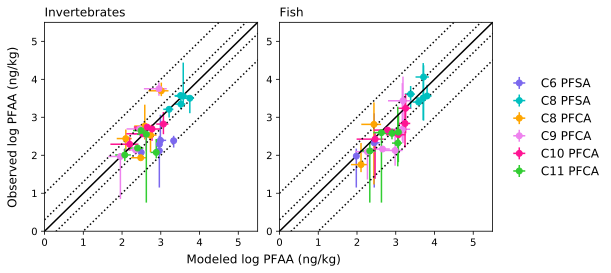

In [178]:
## Plot modeled vs. observed concentrations 1:1 -- 
%config InlineBackend.figure_format = 'svg'

# Select species of interest
OrgType = 'Invertebrates' # Fish or Invertebrates


PlotData = AllData
PlotData.set_index('PFAA',inplace=True, drop=False)

# Subset Data
FishData = PlotData[PlotData.SppAlias.isin(['Sol','Fln','Gob','CSb','Acy','Spr'])]
InvData = PlotData[PlotData.SppAlias.isin(['Cop','Mys','Rag','WSh','Gam'])]

DataList = [InvData, FishData]
Plot_label = ['Invertebrates','Fish']

# Set up PFAAs and labels for plot looping
PFAS_List = ['PFHxS','PFOS','PFOA','PFNA','PFDA','PFUA']
PFAS_labels = ['C6 PFSA','C8 PFSA','C8 PFCA', 'C9 PFCA','C10 PFCA','C11 PFCA']
PFAS_colors = ['mediumslateblue','c','orange','violet','deeppink','limegreen']

    
# Plot
fig, ax = plt.subplots(1, 2, figsize=(6.6, 3.5))


for (i, PlotData) in enumerate([InvData,FishData]): 
    pltfmt = ax[i] if len(DataList) <= 3 else ax[i//cols, i%cols]
    pltfmt.set_title(Plot_label[i], fontsize='large',loc='left') # inverts
    
    for (j, PFAA) in enumerate(PFAS_List):
        pltfmt.errorbar(PlotData.loc[PFAA,'log_ngkg_re'],PlotData.loc[PFAA,'Obs_logngkg'], label=PFAS_labels[j],
            yerr = [PlotData.loc[PFAA,'Obs_logngkg_Lo'], PlotData.loc[PFAA,'Obs_logngkg_Up']],
            xerr = [PlotData.loc[PFAA,'logngkg_re_Lo'], PlotData.loc[PFAA,'logngkg_re_Up']], c=PFAS_colors[j],fmt='o')

        
    # 1:1 lines
    x = np.arange (0,7)
    y = x
    y1 = x - 1
    y2 = x + 1
    y3 = x - np.log10(2)
    y4 = x + np.log10(2)

    pltfmt.plot(x, y, c='black')
    pltfmt.plot(x, y1, c='black', linestyle='dotted')
    pltfmt.plot(x, y2, c='black', linestyle='dotted')
    pltfmt.plot(x, y3, c='black', linestyle='dotted') # factor of 2 off
    pltfmt.plot(x, y4, c='black', linestyle='dotted') # factor of 2 off
    pltfmt.set_ylim(0,5.5)
    pltfmt.set_xlim(0,5.5)

# formatting
fig.tight_layout(pad=0.5)
fig.text(0.5, -0.04, 'Modeled log PFAA (ng/kg)', ha='center', fontsize='large')
fig.text(-0.04, 0.5, 'Observed log PFAA (ng/kg)', va='center', rotation='vertical', fontsize='large')
    
pltfmt.legend(loc=1, fontsize='large',frameon=False, bbox_to_anchor=(1.55,0.785))





